#kobert

In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master
!pip install transformers==3

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-_0xhe2ll
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-_0xhe2ll
  Created wheel for kobert: filename=kobert-0.1.2-cp37-none-any.whl size=12718 sha256=47aa1ce469c4598ec04f0d23af5dcdaa45ba3b53928e752c21639fadd9a3dc8c
  Stored in directory: /tmp/pip-ephem-wheel-cache-2vhaao77/wheels/a2/b0/41/435ee4e918f91918be41529283c5ff86cd010f02e7525aecf3
Successfully built kobert


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [ ]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

In [ ]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
##GPU 사용 시
device = torch.device("cuda:0")

In [ ]:
bertmodel, vocab = get_pytorch_kobert_model()

using cached model
using cached model


In [ ]:
!wget https://www.dropbox.com/s/374ftkec978br3d/ratings_train.txt?dl=1
!wget https://www.dropbox.com/s/977gbwh542gdy94/ratings_test.txt?dl=1

--2021-06-12 08:39:45--  https://www.dropbox.com/s/374ftkec978br3d/ratings_train.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/374ftkec978br3d/ratings_train.txt [following]
--2021-06-12 08:39:45--  https://www.dropbox.com/s/dl/374ftkec978br3d/ratings_train.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca115bf07e2a26d42bb867f41f6.dl.dropboxusercontent.com/cd/0/get/BQTBBxsyJJJkUCWuNIv3FGtO9BDjmHNYcwVMqhTwiwFUHt8UqYibKa6PEU8aKnfMVn3MDk84G_o2MQir3IOJ1c7ermygdQKMX9N7bXIDipaCG0rlpkRQkL7dHT7ja9p6eULnlR_Q3J_qGmIx3uNjxLuE/file?dl=1# [following]
--2021-06-12 08:39:45--  https://uca115bf07e2a26d42bb867f41f6.dl.dropboxusercontent.com/cd/0/get/BQTBBxsyJJJkUCWuNIv3FGtO9BDjmHNYcwVMqhTwiwFUHt8UqYibKa6PEU8aKnfMVn3MDk84G

In [ ]:
dataset_train = nlp.data.TSVDataset("ratings_train.txt?dl=1", field_indices=[1,2], num_discard_samples=1)
dataset_test = nlp.data.TSVDataset("ratings_test.txt?dl=1", field_indices=[1,2], num_discard_samples=1)

In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


In [ ]:
## Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 4
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
##GPU 사용 시
device = torch.device("cuda:0")

In [ ]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)
#model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

RuntimeError: ignored

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device) #token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device) #segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device) #label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    '''
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    '''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 0.6976163983345032 train acc 0.453125
epoch 1 batch id 201 loss 0.42816367745399475 train acc 0.5907182835820896
epoch 1 batch id 401 loss 0.40627816319465637 train acc 0.6946695760598504
epoch 1 batch id 601 loss 0.44703763723373413 train acc 0.7426944675540765
epoch 1 batch id 801 loss 0.43533122539520264 train acc 0.7693313046192259
epoch 1 batch id 1001 loss 0.3130257725715637 train acc 0.7850586913086913
epoch 1 batch id 1201 loss 0.34130293130874634 train acc 0.7970831598667777
epoch 1 batch id 1401 loss 0.28604239225387573 train acc 0.8055741434689507
epoch 1 batch id 1601 loss 0.44335880875587463 train acc 0.813192926296065
epoch 1 batch id 1801 loss 0.2218915969133377 train acc 0.8193798584119933
epoch 1 batch id 2001 loss 0.3079429864883423 train acc 0.824931284357821
epoch 1 batch id 2201 loss 0.31504759192466736 train acc 0.8296654929577465

epoch 1 train acc 0.8331222447383391


epoch 2 batch id 1 loss 0.5636889338493347 train acc 0.796875
epoch 2 batch id 201 loss 0.197922021150589 train acc 0.8812189054726368
epoch 2 batch id 401 loss 0.24106742441654205 train acc 0.8852478179551122
epoch 2 batch id 601 loss 0.3745824098587036 train acc 0.8893770798668885
epoch 2 batch id 801 loss 0.35937395691871643 train acc 0.8913857677902621
epoch 2 batch id 1001 loss 0.18314515054225922 train acc 0.8944493006993007
epoch 2 batch id 1201 loss 0.2147497832775116 train acc 0.8972340757701915
epoch 2 batch id 1401 loss 0.17776483297348022 train acc 0.8994914346895075
epoch 2 batch id 1601 loss 0.31865450739860535 train acc 0.9014678326046222
epoch 2 batch id 1801 loss 0.14583775401115417 train acc 0.9032742226540811
epoch 2 batch id 2001 loss 0.25535497069358826 train acc 0.9051958395802099
epoch 2 batch id 2201 loss 0.23146595060825348 train acc 0.9064274761472059

epoch 2 train acc 0.907769837883959


epoch 3 batch id 1 loss 0.4210139513015747 train acc 0.828125
epoch 3 batch id 201 loss 0.09554987400770187 train acc 0.9270833333333334
epoch 3 batch id 401 loss 0.14957553148269653 train acc 0.9306031795511222
epoch 3 batch id 601 loss 0.24531897902488708 train acc 0.9333662645590682
epoch 3 batch id 801 loss 0.19244159758090973 train acc 0.9358614232209738
epoch 3 batch id 1001 loss 0.2600962519645691 train acc 0.9379995004995005
epoch 3 batch id 1201 loss 0.06552460044622421 train acc 0.9401930682764363
epoch 3 batch id 1401 loss 0.1323031485080719 train acc 0.9418384189864383
epoch 3 batch id 1601 loss 0.29337531328201294 train acc 0.9427701436602124
epoch 3 batch id 1801 loss 0.10705951601266861 train acc 0.9443885341476957
epoch 3 batch id 2001 loss 0.1036829799413681 train acc 0.9455272363818091
epoch 3 batch id 2201 loss 0.16795851290225983 train acc 0.9464589959109496

epoch 3 train acc 0.947265625


epoch 4 batch id 1 loss 0.4777551293373108 train acc 0.828125
epoch 4 batch id 201 loss 0.04789390787482262 train acc 0.9612873134328358
epoch 4 batch id 401 loss 0.09578289091587067 train acc 0.962281795511222
epoch 4 batch id 601 loss 0.17890143394470215 train acc 0.9637063227953411
epoch 4 batch id 801 loss 0.06566263735294342 train acc 0.9643804619225967
epoch 4 batch id 1001 loss 0.10973767936229706 train acc 0.9651910589410589
epoch 4 batch id 1201 loss 0.018879273906350136 train acc 0.9662000416319734
epoch 4 batch id 1401 loss 0.028870437294244766 train acc 0.9666755888650964
epoch 4 batch id 1601 loss 0.22636373341083527 train acc 0.9673251093066834
epoch 4 batch id 1801 loss 0.0915280357003212 train acc 0.9680819683509162
epoch 4 batch id 2001 loss 0.12060706317424774 train acc 0.9686250624687656
epoch 4 batch id 2201 loss 0.05312257260084152 train acc 0.9688706837801

epoch 4 train acc 0.969183287116041


In [ ]:
'''
#GPU에서 저장 후 GPU에서 불러오기
PATH1 = '/content/drive/MyDrive/텍마_개인폴더/kobert_train2.pt'
PATH2 = '/content/drive/MyDrive/텍마_개인폴더/kobert_all2.pt'
torch.save(model.state_dict(), PATH1)
torch.save(model, PATH2)
'''

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim

# 모델 정의
class TheModelClass(nn.Module):
    def __init__(self):
        super(TheModelClass, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
'''
# 모델 초기화
new_model = TheModelClass()

# 옵티마이저 초기화
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)

# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", new_model.state_dict()[param_tensor].size())

# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])
'''

'\n# 모델 초기화\nnew_model = TheModelClass()\n\n# 옵티마이저 초기화\noptimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)\n\n# 모델의 state_dict 출력\nprint("Model\'s state_dict:")\nfor param_tensor in model.state_dict():\n    print(param_tensor, "\t", new_model.state_dict()[param_tensor].size())\n\n# 옵티마이저의 state_dict 출력\nprint("Optimizer\'s state_dict:")\nfor var_name in optimizer.state_dict():\n    print(var_name, "\t", optimizer.state_dict()[var_name])\n'

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/텍마_개인폴더/kobert/트위티프로포즈_댓글.csv',index_col=0)
data.columns=['comments']
data["comments"]=data["comments"].apply(lambda x: ' '.join(x.strip().split()))
data["label"] = 1
data.head()

,comments,label
0,유니콘이구나 유니콘이야,1
1,해리 포터 모자,1
2,사랑해 정말 스위트하시다,1
3,아니 못 잔 날 합치면 일주일 될 듯,1
4,저런 남잔 어디서 만나나요,1


In [ ]:
data[["comments","label"]].to_csv("/content/drive/My Drive/텍마_개인폴더/트위티프로포즈_댓글.txt", sep='\t', index=False)
dataset_test = nlp.data.TSVDataset("/content/drive/My Drive/텍마_개인폴더/트위티프로포즈_댓글.txt", field_indices=[0,1], num_discard_samples=1)
data_test = BERTDataset(dataset_test, 0, 1, tok, 128, True, False)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=64, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
'''
#불러오기
device = torch.device("cuda")
new_model = TheModelClass()
new_model = torch.load(PATH2)
new_model.to(device)
'''

'\n#불러오기\ndevice = torch.device("cuda")\nnew_model = TheModelClass()\nnew_model = torch.load(PATH2)\nnew_model.to(device)\n'

In [ ]:
model.eval()

def model_pred(arg_list):
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
    token_ids = token_ids.long().to(device) #token_ids = token_ids.long().to(device)
    valid_length = valid_length
    segment_ids = segment_ids.long().to(device) #segment_ids = segment_ids.long().to(device)
    label = label.long().to(device) #label = label.long().to(device)
    pred_var = model(token_ids, valid_length, segment_ids)
    _, predict = torch.max(pred_var,1)
    arg_list.extend(predict.tolist())

list_pred = []
model_pred(list_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data["label"] = list_pred
data = data[["comments","label"]]
data

,comments,label
0,유니콘이구나 유니콘이야,0
1,해리 포터 모자,0
2,사랑해 정말 스위트하시다,1
3,아니 못 잔 날 합치면 일주일 될 듯,1
4,저런 남잔 어디서 만나나요,1
...,...,...
2145,행벅하세요,0
2146,언니 영상 보면서 처음 댓글 남겨봐요 보면서 제가 다 눈물 났어요 진짜로 너무 이쁜...,1
2147,드디어 프러포즈 영상이라니 떨리는 마음 부여잡고 보러 갔다 왔는데 저 같이 울었어요...,1
2148,저도 눈물 나요 진짜 너무 이뻐요,1


In [ ]:
data["label"] = list_pred
print(data.groupby("label").size())

label
0     309
1    1841
dtype: int64


In [ ]:
# 부정
data[data["label"]==0]

,comments,label
0,유니콘이구나 유니콘이야,0
1,해리 포터 모자,0
6,나도 내 여자를 감동시키기 위해 머리 싸맬 날이 오겠지,0
7,잘 참고했습니다 명이 답지 같아요,0
8,아니 여기 남자가 클래시에요,0
...,...,...
2137,꺄아아아아앙아 드디어,0
2140,보기 싫어요 아까워서 지금 볼까 말까 맨날 영상 엄청 기다리는데 막상 뜨면 진짜 보...,0
2144,이거 보려고 새로 고침을 몇 번을 했는지 정말,0
2145,행벅하세요,0


In [ ]:
# 긍정
data[data["label"]==1]

,comments,label
2,사랑해 정말 스위트하시다,1
3,아니 못 잔 날 합치면 일주일 될 듯,1
4,저런 남잔 어디서 만나나요,1
5,스위티님은 진짜 내 여자를 공주님으로 만들어 주는 남자 같아요 프러포즈 로망 같은 ...,1
9,페이스북 보고 영상 보러 왔네요,1
...,...,...
2142,제가 다 떨리네요,1
2143,너무 보고 싶었어요,1
2146,언니 영상 보면서 처음 댓글 남겨봐요 보면서 제가 다 눈물 났어요 진짜로 너무 이쁜...,1
2147,드디어 프러포즈 영상이라니 떨리는 마음 부여잡고 보러 갔다 왔는데 저 같이 울었어요...,1


In [ ]:
data.to_csv('/content/drive/My Drive/텍마_개인폴더/kobert/트위티프로포즈댓글_감성분석.csv',encoding='utf-8-sig')

#워드클라우드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/텍마_개인폴더/kobert/트위티프로포즈댓글_감성분석.csv',index_col=0)
df['comments']

0                                            유니콘이구나 유니콘이야
1                                                해리 포터 모자
2                                           사랑해 정말 스위트하시다
3                                    아니 못 잔 날 합치면 일주일 될 듯
4                                          저런 남잔 어디서 만나나요
                              ...                        
2145                                                행벅하세요
2146    언니 영상 보면서 처음 댓글 남겨봐요 보면서 제가 다 눈물 났어요 진짜로 너무 이쁜...
2147    드디어 프러포즈 영상이라니 떨리는 마음 부여잡고 보러 갔다 왔는데 저 같이 울었어요...
2148                                   저도 눈물 나요 진짜 너무 이뻐요
2149                                           다 보고 수정했어요
Name: comments, Length: 2150, dtype: object

In [ ]:
!pip install customized_konlpy
!pip install konlpy
!apt-get update -qq
!apt-get install fonts-nanum* -qq
! pip install wordcloud

In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()

NanumGothic Eco


In [ ]:
stopwords = ['트위티','진짜','어요','해주','까지','어서','정말','해주시','그냥','보고','면서','항상','하나','가득','내내','보기','중하','여서','로그','완죠','주시','다가',
             '요즘','대박','다음','언니','의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','하다','지금','덕분','완전','처럼','바로','만큼']

In [ ]:
from ckonlpy.tag import Twitter
twitter = Twitter()
comments = df['comments']

#word2vec
vec = []
for comment in comments:
    vec2 = []
    tm_ls = twitter.nouns(comment)
    tm_ls = [word for word in tm_ls if not word in stopwords] # 불용어 제거
    for j in range(len(tm_ls)): #비어있지 않은 리스트 중에서 단어가 한 음절인 것은 pass
        if len(tm_ls[j]) > 1:
            vec2.append(tm_ls[j])
        else:
            pass
    vec.append(vec2)

/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [ ]:
noun_list = []
for i in vec:
  noun_list.extend(i)

from collections import Counter

# 빈도수 계산
count = Counter(noun_list)

# 상위 30건 추출
print(count.most_common(30))

# 상위 100건 추출
most = count.most_common(100)

# 딕셔너리 구성
tags = {}
for n, c in most:
  tags[n] = c

[('행복', 988), ('축하', 491), ('영상', 443), ('결혼', 406), ('프러포즈', 337), ('눈물', 325), ('스위티', 267), ('사랑', 200), ('감동', 199), ('남자', 126), ('사람', 116), ('남자친구', 89), ('주책', 80), ('진심', 79), ('오래오래', 79), ('커플', 75), ('준비', 74), ('생각', 67), ('부터', 65), ('평생', 64), ('처음', 62), ('모습', 55), ('서로', 55), ('댓글', 53), ('브이', 51), ('남편', 49), ('세상', 48), ('응원', 47), ('여자', 45), ('위트', 44)]


<Figure size 432x288 with 0 Axes>

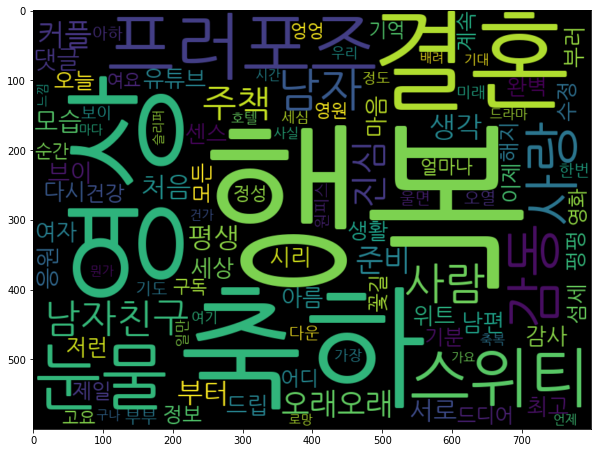

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(font_path="NanumGothic", background_color='black', width=800, height=600)
gen = wc.generate_from_frequencies(tags)
plt.figure()
plt.figure(figsize=(10, 8))
plt.imshow(gen, interpolation='bilinear')